In [1]:
import re
!pip install imblearn
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_extraction.text import TfidfTransformer
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

You should consider upgrading via the 'c:\users\jurus\desktop\machine learing lab auta\python.exe -m pip install --upgrade pip' command.


In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import nltk
import html
import gensim
from gensim.models import word2vec
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk import ngrams
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
from collections import defaultdict

from sklearn.model_selection import train_test_split
from sklearn import feature_extraction, model_selection, manifold
from sklearn.metrics import precision_recall_curve, accuracy_score, confusion_matrix, roc_auc_score, classification_report, roc_curve, auc

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential

c:\users\jurus\desktop\machine learing lab auta\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [3]:
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jurus\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\jurus\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [4]:
#DATA

df_train = pd.read_csv("C:/Users/jurus/Documents/AGH/Praca inżynierska/data_2/train.csv")
df_test = pd.read_csv("C:/Users/jurus/Documents/AGH/Praca inżynierska/data_2/test.csv")
df_labels = pd.read_csv("C:/Users/jurus/Documents/AGH/Praca inżynierska/data_2/submit.csv")

df_test['label'] = df_labels['label']

df = pd.concat([df_train, df_test]).reset_index(drop=True)

df.drop(columns=['author'], inplace=True)

# Combining 'title' and 'text' colmuns together
df['original'] = df['title'] + ' ' + df['text']

In [5]:
# Shuffling data
df = df.sample(frac=1)
# Dropping duplicates & NaN rows
df.drop_duplicates(subset=['text'], inplace=True)
df.dropna(subset = ["text"], inplace=True)
df.dropna(subset = ["title"], inplace=True)

In [6]:
print(df[df.label == 1].shape[0])
print(df[df.label == 0].shape[0])

12102
12700


In [7]:
#DATA CLEANING

# Obtaining additional stopwords from nltk
stop_words = stopwords.words('english')

def cleaning(text):
    clean = re.sub('<.*?>', ' ', str(text))         
#removes HTML tags
    clean = re.sub('\'.*?\s',' ', clean)               
#removes all hanging letters afer apostrophes (s in it's)
    clean = re.sub(r'http\S+',' ', clean)              
#removes URLs
    clean = re.sub('\W+',' ', clean)                   
#replacing the non alphanumeric characters
    return html.unescape(clean)
df['cleaned'] = df['original'].apply(cleaning)


def stopwords(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        # Taking words that don't belong to stopwords and have more than 2 characters
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3 and token not in stop_words:
            result.append(token)

    return result
df['nostopwords'] = df['cleaned'].apply(stopwords)

In [8]:
# Lemmatizing
wnl = WordNetLemmatizer()
df['clean_lemm'] = df['nostopwords'].apply(lambda x: [wnl.lemmatize(word, pos="v") for word in x])
df['clean_lemm'] = df['clean_lemm'].apply(lambda x: [wnl.lemmatize(word, pos="a") for word in x])
df['clean_lemm'] = df['clean_lemm'].apply(lambda x: [wnl.lemmatize(word, pos="n") for word in x])

In [9]:
# All unique words present in dataset in one string
df['clean_joined'] = df['clean_lemm'].apply(lambda x: " ".join(x))
print(df['clean_joined'])

3149     family terror victim urge fifa palestinian soc...
9758     fidel castro cuban revolutionary defy die york...
4537     asuntos internos investigará policía tonta esp...
5888     china machado breakthrough model die york time...
9092     actress mayim bialik contradict anti israel ac...
                               ...                        
23928    canada immigration crisis american leftist pos...
16948    great comet party go broadway dish pierogies j...
973      oroville state federal government share blame ...
1374     europa league matchday zenit rule zenit dundal...
5150     critique hillary clinton ready attack york tim...
Name: clean_joined, Length: 24802, dtype: object


In [10]:
#COUNT VECTORIZER - counts  the occurrence of each word for every single text in order to create a vector

from sklearn.feature_extraction.text import CountVectorizer

X_train, X_test, y_train, y_test = train_test_split(df.clean_joined, df.label, test_size=0.2)

#vectorizer = CountVectorizer(ngram_range=(1,2))
vectorizer = CountVectorizer(min_df=5, max_df=5000)
vectorizer.fit(df['clean_joined'])
# Transforming training and validation data using count vectorizer object
X_train_count = vectorizer.transform(X_train.values)
X_test_count = vectorizer.transform(X_test.values)


Model accuracy is :  0.816569240072566
              precision    recall  f1-score   support

           0       0.79      0.87      0.83      2559
           1       0.85      0.75      0.80      2402

    accuracy                           0.82      4961
   macro avg       0.82      0.81      0.82      4961
weighted avg       0.82      0.82      0.82      4961



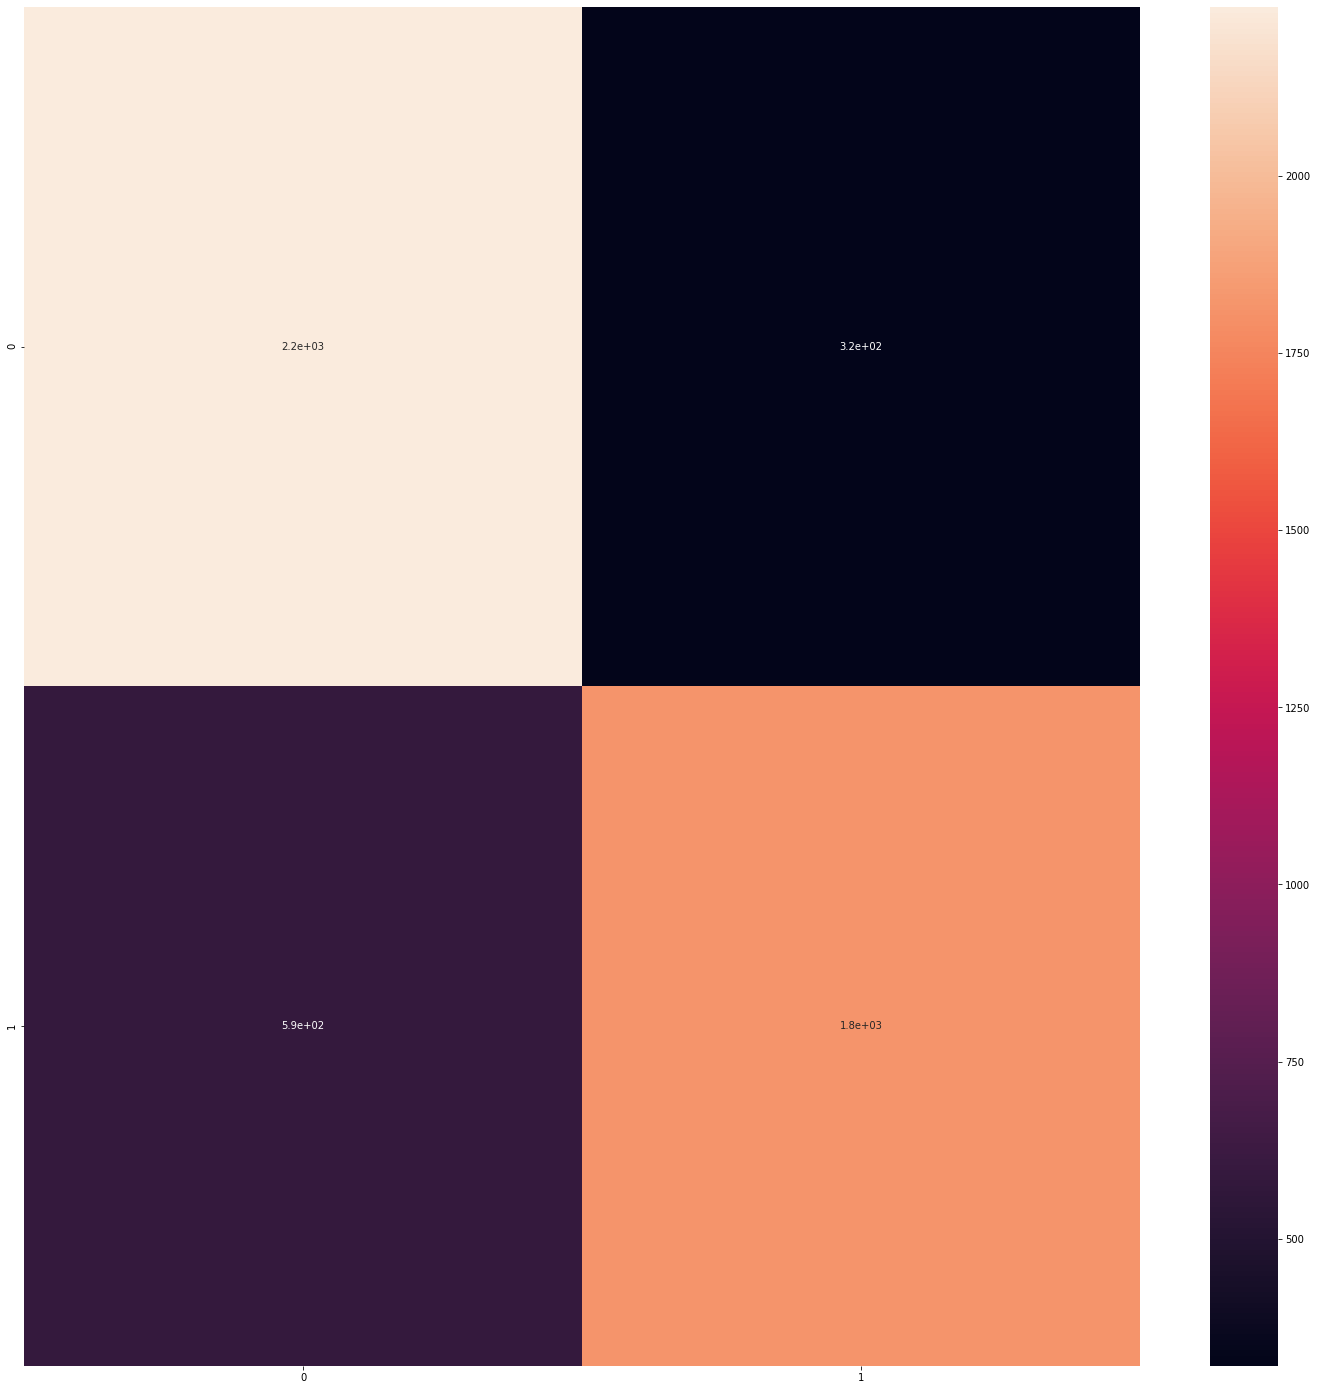

In [12]:
# NAIVE BAYES CLASSIFIER

from sklearn import naive_bayes

model = naive_bayes.MultinomialNB()
model.fit(X_train_count, y_train)

## Plot confusion matrix

pred = model.predict(X_test_count)

prediction = []
# If hte prediction is > 0.5 then the news is real otherwise it is fake
for i in range(len(pred)):
    if pred[i].item() > 0.5:
        prediction.append(1)
    else:
        prediction.append(0)

# Getting accuracy
accuracy = accuracy_score(list(y_test), prediction)
print("Model accuracy is : ", accuracy)
print(classification_report(y_test, prediction))

# Confusion matrix
c_matrix = confusion_matrix(list(y_test), prediction)
plt.figure(figsize=(25,25))
sns.heatmap(c_matrix, annot=True)
plt.show()

In [ ]:
# Frequency of the words in a vectorizer
sum_words = X_train_count.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)

In [ ]:
words_freq

In [13]:
neg_class_prob_sorted = model.feature_log_prob_[0, :].argsort()[::-1]

print(np.take(vectorizer.get_feature_names(), neg_class_prob_sorted[:200]))

['company' 'republican' 'percent' 'police' 'vote' 'attack' 'school'
 'court' 'administration' 'child' 'breitbart' 'security' 'play' 'federal'
 'leader' 'office' 'department' 'team' 'order' 'build' 'russia' 'democrat'
 'business' 'kill' 'executive' 'health' 'statement' 'meet' 'university'
 'officer' 'interview' 'rule' 'deal' 'russian' 'black' 'game' 'military'
 'chief' 'program' 'night' 'china' 'email' 'money' 'hear' 'little'
 'general' 'fight' 'service' 'feel' 'offer' 'director' 'story' 'lose'
 'care' 'center' 'voter' 'decision' 'young' 'remain' 'student' 'shoot'
 'spend' 'release' 'effort' 'problem' 'agency' 'stand' 'north'
 'presidential' 'provide' 'charge' 'record' 'friend' 'control' 'line'
 'head' 'judge' 'grow' 'create' 'note' 'street' 'foreign' 'friday'
 'market' 'best' 'study' 'get' 'book' 'justice' 'small' 'stop' 'social'
 'investigation' 'view' 'base' 'democratic' 'clear' 'sign' 'concern'
 'community' 'area' 'send' 'away' 'receive' 'past' 'increase' 'return'
 'death' 'major' '

In [14]:
pos_class_prob_sorted = model.feature_log_prob_[1, :].argsort()[::-1]
print(np.take(vectorizer.get_feature_names(), pos_class_prob_sorted[:200]))

['vote' 'email' 'russia' 'russian' 'military' 'police' 'republican'
 'attack' 'october' 'child' 'video' 'syria' 'control' 'money' 'black'
 'order' 'source' 'investigation' 'november' 'article' 'today'
 'presidential' 'voter' 'comment' 'candidate' 'result' 'information'
 'free' 'federal' 'water' 'create' 'stand' 'foreign' 'human' 'percent'
 'real' 'security' 'base' 'story' 'problem' 'kill' 'fight' 'cause'
 'democratic' 'break' 'department' 'bank' 'read' 'democrat' 'health'
 'stop' 'send' 'release' 'get' 'lose' 'company' 'history' 'anti' 'note'
 'reason' 'hand' 'rule' 'matter' 'comey' 'build' 'actually' 'office'
 'word' 'general' 'poll' 'leader' 'action' 'provide' 'john' 'feel' 'food'
 'deal' 'social' 'area' 'market' 'increase' 'head' 'china' 'global'
 'court' 'school' 'evidence' 'clear' 'line' 'little' 'best' 'watch'
 'important' 'away' 'play' 'course' 'hear' 'understand' 'economic'
 'secretary' 'justice' 'business' 'crime' 'israel' 'foundation'
 'administration' 'syrian' 'international